In [1]:
import json
import cv2
from PIL import Image, ImageFile
from glob import glob
import time
import matplotlib.patches as patches
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import gc
gc.collect()
torch.cuda.empty_cache()

device = torch.device('cuda')
torch.cuda.empty_cache()

ImageFile.LOAD_TRUNCATED_IMAGES = True

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

'''
{'filename': '5f656a0f627a3ef96dec882437e3e7ada1c7a877201cf54dcd7a2c4508588ff3_여_30_기쁨_공공시설&종교&의료시설_20201204105732-001-007.jpg',
 'gender': '여',
 'age': 30,
 'isProf': '전문인',
 'faceExp_uploader': '기쁨',
 'bg_uploader': '공공시설/종교/의료시설',
 'annot_A': {'boxes': {'maxX': 1912.2253,
   'maxY': 1581.6027,
   'minX': 1187.4949,
   'minY': 579.22235},
  'faceExp': '기쁨',
  'bg': '공공시설/종교/의료'},
 'annot_B': {'boxes': {'maxX': 1912.348108621648,
   'maxY': 1572.1522585800617,
   'minX': 1206.363701502596,
   'minY': 579.1777983055337},
  'faceExp': '기쁨',
  'bg': '공공시설/종교/의료'},
 'annot_C': {'boxes': {'maxX': 1890.909447114109,
   'maxY': 1567.448627450284,
   'minX': 1183.8414475546967,
   'minY': 596.9434661684523},
  'faceExp': '기쁨',
  'bg': '공공시설/종교/의료'}}
'''

In [2]:
class BaegDataset(Dataset):
    def __init__(self , transform = None):
        self.transform = transform
        # image dataset
        # image dataset 병합
        
        
            
        
        self.data_list = glob('/data/Emotion_data/Validation/image/*')
        self.label_list = glob("/data/Emotion_data/Validation/label/*")
            
        # label map
        self.label_map = {
            '기쁨' : 1,
            '상처' : 2,
            '당황' : 3,
            '분노' : 4,
            '불안' : 5,
            '슬픔' : 6,
            '중립' : 7
        }
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        # load images and mask
        img_path = self.data_list[idx]
        img = Image.open(img_path).convert("RGB")
        
        if self.transform  is not None:
            img = self.transform(img)
            
        # 1. filename만 따로 빼서 for문 돌려서 json_list에 있는 것과 비교
        img_name = img_path.split('/')
        mask = {}
        for json_list in self.label_list:
            with open(json_list, 'r') as f:
                json_data = json.load(f)
                for i in range(0, len(json_data)):
                    filename = json_data[i]['filename']
                    if filename == img_name[-1]:
                        mask = json_data[i]
                        
        
        # area : box의 면적으로써 나중에 IOU구하려고 만든거.
        x_min = mask['annot_A']['boxes']['minX']
        x_max = mask['annot_A']['boxes']['maxX']
        y_min = mask['annot_A']['boxes']['minY']
        y_max = mask['annot_A']['boxes']['maxY']
        boxes = [x_min, y_min, x_max, y_max]
        boxes = torch.as_tensor(boxes, dtype = torch.float32)
        boxes = boxes.unsqueeze(0)
        
        #area = (boxes[3] - boxes[1]) * (boxes[2] - boxes[0])
        
        # label
        label = self.label_map[mask['faceExp_uploader']]
        label = torch.as_tensor(label, dtype=torch.int64)
        # return target
        target = {}
        target["boxes"] = boxes
        target["labels"] = label.unsqueeze(0)
        #target["area"] = area.to(device)
        

        return img, target

In [3]:
def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]
        
        
        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 2 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [4]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [5]:
transform = transforms.Compose([transforms.ToTensor(), ])
#transforms.Resize([600, 1000])

In [6]:
dataset = BaegDataset(transform)

Target :  tensor([1])


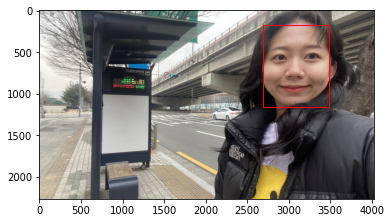

In [7]:
_idx = 140
img, annotations = dataset[_idx]
print("Target : ", annotations['labels'])
plot_image_from_output(img, annotations)
# print("Prediction : ", preds[_idx]['labels'])
# plot_image_from_output(imgs[_idx], preds[_idx])

In [8]:
# fine tuning (frozen X)

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)

num_classes = 8 

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [9]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_datset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [10]:
print(len(train_dataset))
print(len(test_datset))

41711
10428


In [17]:
#train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=collate_fn)

In [18]:
#test_data_loader = torch.utils.data.DataLoader(test_datset, batch_size = 2, shuffle=False, num_workers=0)
test_data_loader = torch.utils.data.DataLoader(test_datset, batch_size = 2, shuffle=False, num_workers=0, collate_fn=collate_fn)

In [19]:
# optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0006)

In [20]:
num_epochs = 15

In [ ]:
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    i = 0
    j = 0
    epoch_loss = 0
    for imgs, labels in train_data_loader:
        try:
            i += 1
            j += 1
            imgs = list(img.to(device) for img in imgs)
            annotations = [{k: v.to(device) for k, v in t.items()} for t in labels]
            loss_dict = model(imgs, annotations)
        
            losses = sum(loss for loss in loss_dict.values())
            if losses == None:
                print('WARNING: non-finite loss, ending training ')
            optimizer.zero_grad()
        
            losses.backward()
            optimizer.step()
            
            epoch_loss += losses
            if i % 100 == 0:
                print(f'지금 : {j}번째까지의 Loss : {epoch_loss / i}')
                epoch_loss = 0
                i = 0
            if j == 5000:
                torch.save(model.state_dict(), 'model_weights_epoch50000.pth')
                break
        
        except Exception as e:
            print("오류발생")
            continue
        
    print('--------------------------------------------------------------')  
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start_time}')

오류발생
지금 : 100번째까지의 Loss : 0.2005472183227539
지금 : 200번째까지의 Loss : 0.19702263176441193
지금 : 300번째까지의 Loss : 0.1700286865234375
지금 : 400번째까지의 Loss : 0.16028931736946106
지금 : 500번째까지의 Loss : 0.15885399281978607
지금 : 600번째까지의 Loss : 0.16312824189662933
지금 : 700번째까지의 Loss : 0.15355925261974335
오류발생
지금 : 800번째까지의 Loss : 0.15563994646072388
오류발생
지금 : 900번째까지의 Loss : 0.1472584754228592
지금 : 1000번째까지의 Loss : 0.15844330191612244
지금 : 1100번째까지의 Loss : 0.151828795671463
오류발생
지금 : 1200번째까지의 Loss : 0.14387395977973938


In [35]:
torch.save(model.state_dict(), 'model_weights1.pth')

In [16]:
def make_prediction(model, img, threshold):
    
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

Target :  tensor([2], device='cuda:0')


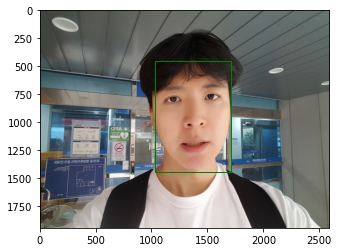

Prediction :  tensor([7, 1, 5, 3, 2, 4, 6, 7, 4, 3, 1, 7, 3, 2, 4, 4, 3, 5], device='cuda:0')


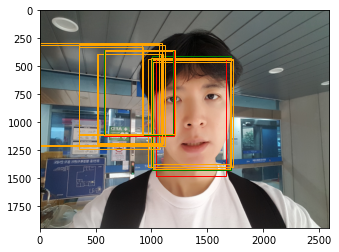

Target :  tensor([1], device='cuda:0')


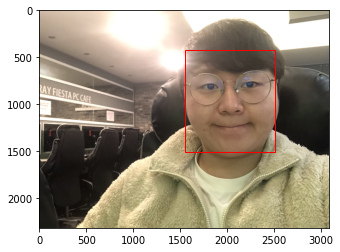

Prediction :  tensor([1, 7, 4, 6, 2, 5, 3], device='cuda:0')


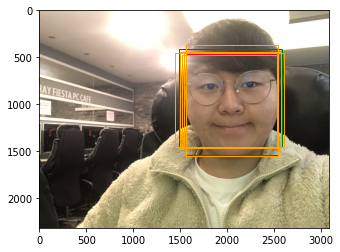

Target :  tensor([3], device='cuda:0')


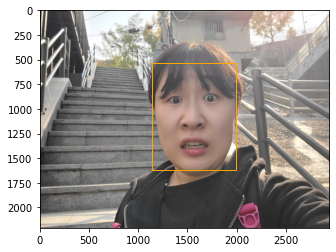

Prediction :  tensor([1, 7, 5, 3, 4, 2, 6], device='cuda:0')


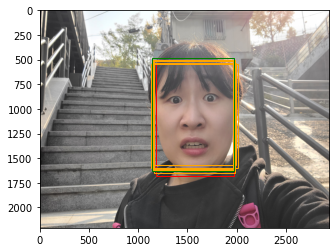

Target :  tensor([7], device='cuda:0')


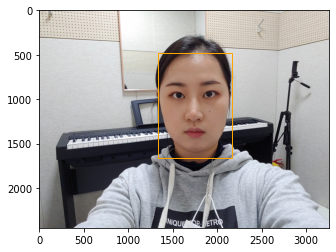

Prediction :  tensor([7, 3, 5, 4, 2, 1, 6], device='cuda:0')


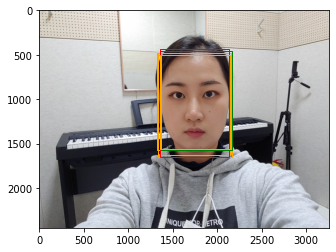

Target :  tensor([4], device='cuda:0')


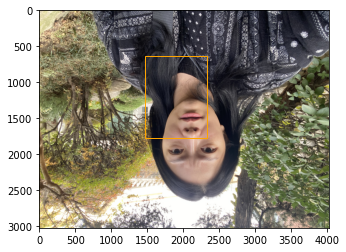

Prediction :  tensor([1, 7, 7, 4, 2, 4, 5, 3, 6, 7, 1, 3, 4, 1, 2, 2, 3, 5, 5, 4, 1, 4, 3, 6,
        7, 2, 5, 6, 5, 2, 3], device='cuda:0')


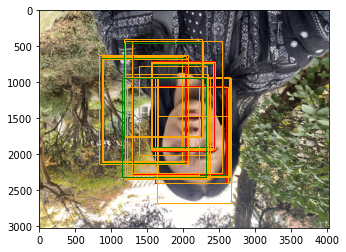

Target :  tensor([6], device='cuda:0')


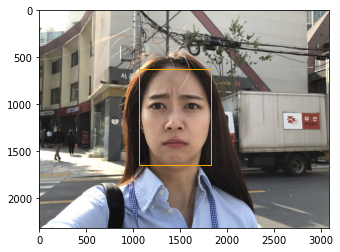

Prediction :  tensor([7, 5, 2, 4, 3, 1, 6], device='cuda:0')


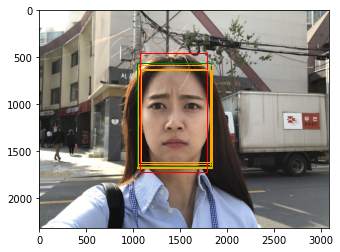

Target :  tensor([3], device='cuda:0')


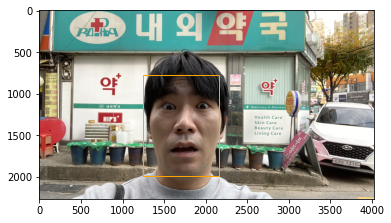

Prediction :  tensor([7, 3, 5, 2, 4, 1, 6], device='cuda:0')


KeyboardInterrupt: 

In [17]:
# 테스트셋 배치사이즈= 2
i = 0
model.eval()
for imgs, labels in test_data_loader:
    annotations = [{k: v.to(device) for k, v in t.items()} for t in labels]
    imgs = list(img.to(device) for img in imgs)
    preds = model(imgs)
    
    
    print("Target : ", annotations[i]['labels'])
    plot_image_from_output(imgs[i], annotations[i])
    print("Prediction : ", preds[i]['labels'])
    plot_image_from_output(imgs[i], preds[i])


Target :  tensor([3], device='cuda:0')


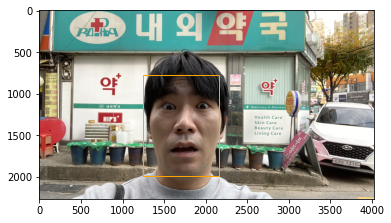

Prediction :  tensor([7, 3, 5, 2, 4, 1, 6], device='cuda:0')


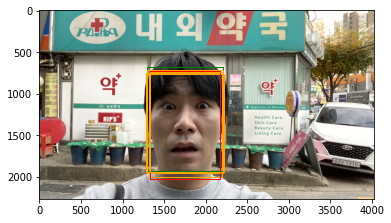

In [20]:
_idx = 0
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output(imgs[_idx], annotations[_idx])
print("Prediction : ", preds[_idx]['labels'])
plot_image_from_output(imgs[_idx], preds[_idx])